## Spectrogram Visualizer
The following notebook enables one to visualize the spectrogram he/she will get during trainig. This code aims to mimic the "getitem" functionalities, and show the spectrogram the model gets

In [1]:
import sys
from pathlib import Path
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import librosa.display


sys.path.append('..')

In [2]:
from soundbay.data import ClassifierDataset

In [3]:
## utils

class DotDictWrapper:
    """
    d['key']==d.key
    """
    def __init__(self, d):
        self._dict = d

    def __getattr__(self, name):
        if name in self._dict:
            return self._dict[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def __getitem__(self, key):
        return self._dict[key]

### Your params here

In [56]:
DATA_PATH = '../datasets/right_whale_noaa/nefsc_sbnms_200903_nopp6_ch10/source-audio/'
METADATA_PATH = '../datasets/right_whale_noaa/train_high_prob.csv'

# load augmentation and preprocessors - you can choose what yaml file to load by changing the path below
with open('../soundbay/conf/preprocessors/_preprocessors.yaml', 'r') as file:
    preprocessors = yaml.safe_load(file)
with open('../soundbay/conf/augmentations/_augmentations.yaml', 'r') as file:
    augmentations = yaml.safe_load(file)
with open('../soundbay/conf/data/right_whale_noaa.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
data = data['data']
preprocessors=preprocessors['_preprocessors']
augmentations = augmentations['_augmentations']

In [57]:
pprint(data)

{'batch_size': 64,
 'data_sample_rate': 2000,
 'hop_length': 128,
 'label_names': ['Noise', 'Call'],
 'max_freq': 1000,
 'min_freq': 0,
 'n_fft': 512,
 'num_workers': 6,
 'sample_rate': 2000,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                   'augmentations': '${_augmentations}',
                   'augmentations_p': 0.8,
                   'data_path': '../datasets/right_whale_noaa/nefsc_sbnms_200903_nopp6_ch10/source-audio/',
                   'data_sample_rate': '${data.data_sample_rate}',
                   'margin_ratio': 0.2,
                   'metadata_path': '../datasets/right_whale_noaa/train_high_prob.csv',
                   'mode': 'train',
                   'path_hierarchy': 0,
                   'preprocessors': '${_preprocessors}',
                   'sample_rate': '${data.sample_rate}',
                   'seq_length': 4.0,
                   'slice_flag': False,
                   'split_metadata_by_label': False},
 'val_dataset': {

In [58]:
## you can tune the parameters from here, or you can change them in the yaml files and then load again
# print(f"before: {data['data_sample_rate']}")
# data['data_sample_rate'] = 48000
# print(f"after: {data['data_sample_rate']}")
data['n_fft'] = 512
data['hop_length'] = 128

In [59]:
aggr_conf = OmegaConf.create({'data':data, 'preprocessors':preprocessors, 'augmentations':augmentations})

In [60]:
cfg = DotDictWrapper({
    'data_path': DATA_PATH,
    'metadata_path': METADATA_PATH,
    'augmentations': aggr_conf.augmentations,
    'augmentations_p': aggr_conf.data.train_dataset.augmentations_p,
    'preprocessors': aggr_conf.preprocessors,
    'seq_length': aggr_conf.data.train_dataset.seq_length,
    'data_sample_rate': aggr_conf.data.data_sample_rate,
    'sample_rate': aggr_conf.data.sample_rate,
    'mode': "train",
    'slice_flag': False,
    'margin_ratio': 0,
    'split_metadata_by_label': False,
})

# cfg_val = ... 

# initiate the dataset

dataset_train = ClassifierDataset(cfg.data_path, cfg.metadata_path, cfg.augmentations, cfg.augmentations_p, cfg.preprocessors,
                 cfg.seq_length, cfg.data_sample_rate, cfg.sample_rate, cfg.mode,
                 cfg.slice_flag, cfg.margin_ratio, cfg.split_metadata_by_label)

In [61]:
dataset_train.metadata.head()

,Selection,View,Channel,Start_DateTime_ISO8601,End_DateTime_ISO8601,Low.Freq..Hz.,High.Freq..Hz.,Species,Detection_Comments,filename,begin_time,end_time,call_length,label
0,1,Spectrogram 1,1,2009-03-28T00:03:08-05:00,2009-03-28T00:03:11-05:00,70.7,174.2,RIWH,NaN,NOPP6_EST_20090328_000000_CH10,188,191,3,1
1,2,Spectrogram 1,1,2009-03-28T00:03:55-05:00,2009-03-28T00:03:58-05:00,83.3,197.0,RIWH,NaN,NOPP6_EST_20090328_000000_CH10,191,235,44,0
2,2,Spectrogram 1,1,2009-03-28T00:03:55-05:00,2009-03-28T00:03:58-05:00,83.3,197.0,RIWH,NaN,NOPP6_EST_20090328_000000_CH10,235,238,3,1
3,3,Spectrogram 1,1,2009-03-28T00:06:38-05:00,2009-03-28T00:06:41-05:00,75.8,151.5,RIWH,NaN,NOPP6_EST_20090328_000000_CH10,238,398,160,0
4,3,Spectrogram 1,1,2009-03-28T00:06:38-05:00,2009-03-28T00:06:41-05:00,75.8,151.5,RIWH,NaN,NOPP6_EST_20090328_000000_CH10,398,401,3,1


___
---

### Functionalities from getitem

In [62]:
"""
__getitem__ method loads item according to idx from the metadata
path_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)
audio = self._get_audio(path_to_file, begin_time, end_time, label, channel)
audio_raw = self.sampler(audio)
audio_augmented = self.augment(audio_raw)
audio_processed = self.preprocessor(audio_augmented)
"""

'\n__getitem__ method loads item according to idx from the metadata\npath_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)\naudio = self._get_audio(path_to_file, begin_time, end_time, label, channel)\naudio_raw = self.sampler(audio)\naudio_augmented = self.augment(audio_raw)\naudio_processed = self.preprocessor(audio_augmented)\n'

In [63]:
def show_spectrogram(audio_processed, title, label):
    plt.figure()
    librosa.display.specshow(audio_processed)
    plt.title(f"{str(title)} label: {label}")
    plt.show()

In [64]:
indices_to_check = [50, 60, 80, 100]

audio.shape: torch.Size([1, 8000])
audio_raw.shape: torch.Size([1, 8000])
audio_augmented.shape: torch.Size([1, 8000])
audio_processed.shape: torch.Size([1, 257, 63])


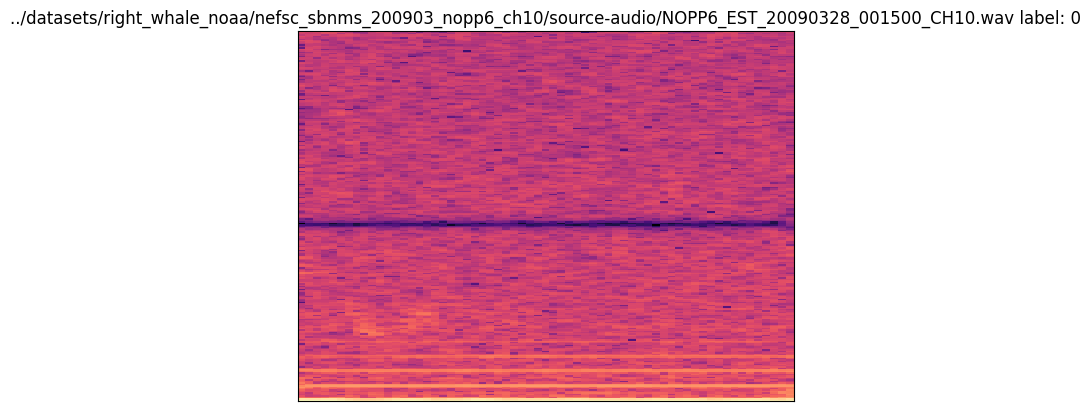

audio.shape: torch.Size([1, 8000])
audio_raw.shape: torch.Size([1, 8000])
audio_augmented.shape: torch.Size([1, 8000])
audio_processed.shape: torch.Size([1, 257, 63])


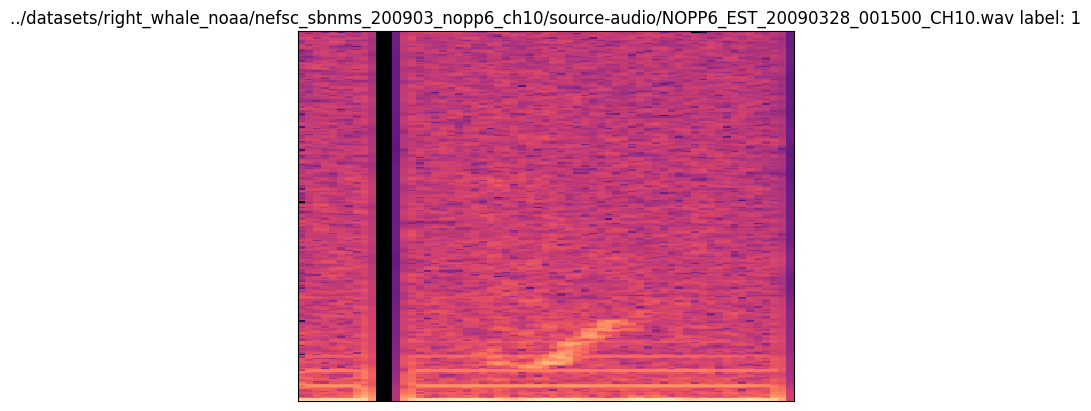

audio.shape: torch.Size([1, 8000])
audio_raw.shape: torch.Size([1, 8000])
audio_augmented.shape: torch.Size([1, 8000])
audio_processed.shape: torch.Size([1, 257, 63])


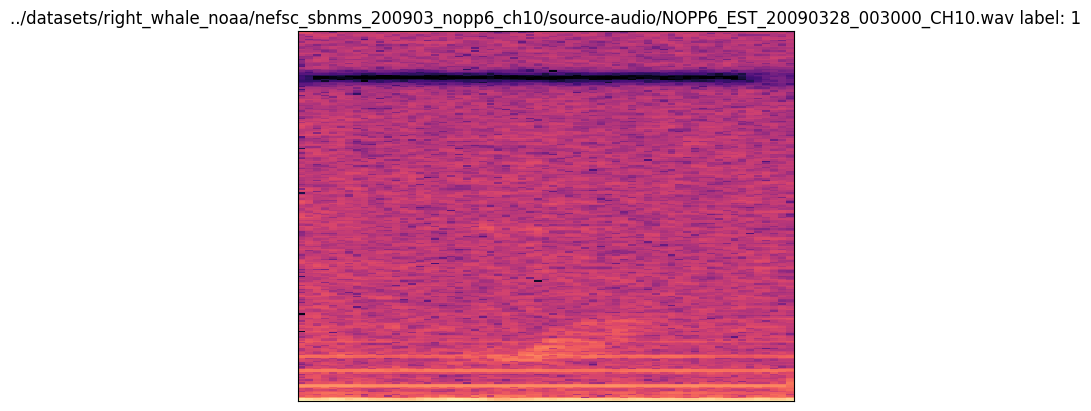

audio.shape: torch.Size([1, 8000])
audio_raw.shape: torch.Size([1, 8000])
audio_augmented.shape: torch.Size([1, 8000])
audio_processed.shape: torch.Size([1, 257, 63])


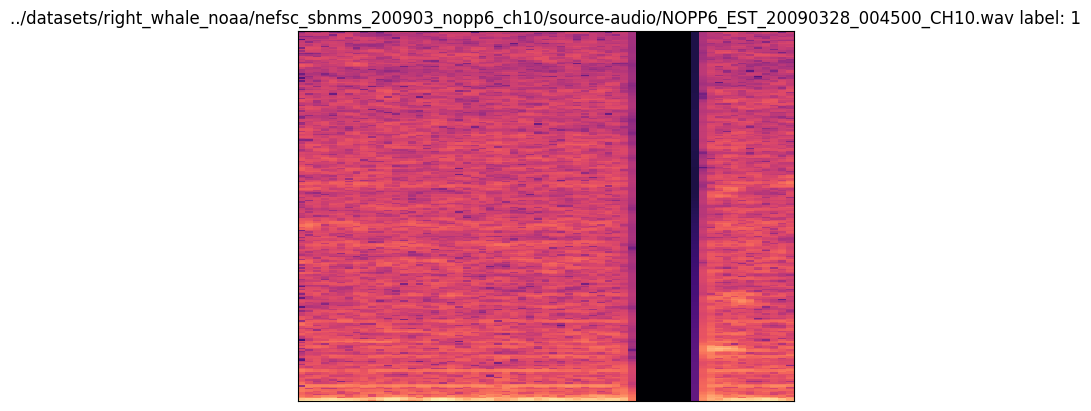

In [65]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, title=path_to_file, label=label)